## Import Libraries

In [1]:
import time
import rospy
import numpy as np
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from dual_quaternion import Quaternion
from dual_quaternion import DualQuaternion
from dual_quaternion import DualQuaternion_body
from casadi import Function
from casadi import jacobian
from dual_quaternion import plot_states_quaternion, plot_states_position, fancy_plots_4, fancy_plots_1, plot_norm_quat, plot_angular_velocities, plot_linear_velocities, fancy_plots_3, plot_norm_real, plot_norm_dual
import osqp
from dual_quaternion import plot_lyapunov, plot_lyapunov_dot
import scipy as sp
from scipy import sparse

### Working with Symbolic Variables and Dualquaternions

In [2]:
# Defining Mobile Robot Frame
qw_1 = ca.MX.sym('qw_1', 1, 1)
qx_1 = ca.MX.sym('qx_1', 1, 1)
qy_1 = ca.MX.sym('qy_1', 1, 1)
qz_1 = ca.MX.sym('qz_1', 1, 1)
q_1 = ca.vertcat(qw_1, qx_1, qy_1, qz_1)
dw_1 = ca.MX.sym("dw_1", 1, 1)
dx_1 = ca.MX.sym("dx_1", 1, 1)
dy_1 = ca.MX.sym("dy_1", 1, 1)
dz_1 = ca.MX.sym("dz_1", 1, 1)
d_1 = ca.vertcat(dw_1, dx_1, dy_1, dz_1)

# Creating auxiliar variables
aux_symbolic_total = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1, dx_1, dy_1, dz_1)
symbolic_actions = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1,dx_1, dy_1, dz_1)
dual_1_data = ca.vertcat(qw_1, qx_1, qy_1, qz_1, dw_1,dx_1, dy_1, dz_1)

### Using Symbolic Variables to Define the Pose Based on Dual Quaternions

In [3]:
theta_1_aux = ca.MX.sym('theta_1_aux', 1, 1)
n_1_aux = ca.MX([0.0, 0.0, 1.0])
q_1_aux = ca.vertcat(ca.cos(theta_1_aux/2), ca.sin(theta_1_aux/2)@n_1_aux)
tx_1_aux = ca.MX.sym("tx_1_aux", 1, 1)
ty_1_aux = ca.MX.sym("ty_1_aux", 1, 1)
t_1_aux = ca.vertcat(0.0, tx_1_aux, ty_1_aux, 0.0)
aux_symbolic_total_aux = ca.vertcat(theta_1_aux, tx_1_aux, ty_1_aux)

### Symbolic Variable Representing the Desired Dual Quaternion

In [4]:
# Defining Desired Frame
qw_1d = ca.MX.sym('qw_1d', 1, 1)
qx_1d = ca.MX.sym('qx_1d', 1, 1)
qy_1d = ca.MX.sym('qy_1d', 1, 1)
qz_1d = ca.MX.sym('qz_1d', 1, 1)
q_1d = ca.vertcat(qw_1d, qx_1d, qy_1d, qz_1d)

dw_1d = ca.MX.sym("dw_1d", 1, 1)
dx_1d = ca.MX.sym("dx_1d", 1, 1)
dy_1d = ca.MX.sym("dy_1d", 1, 1)
dz_1d = ca.MX.sym("dz_1d", 1, 1)
d_1d = ca.vertcat(dw_1d, dx_1d, dy_1d, dz_1d)

# Symbolic Variables
dual_1d_data = ca.vertcat(qw_1d, qx_1d, qy_1d, qz_1d, dw_1d, dx_1d, dy_1d, dz_1d)

# Defining the desired Velocity using symbolics
vx_1d = ca.MX.sym("vx_1d", 1, 1)
vy_1d = ca.MX.sym("vy_1d", 1, 1)
vz_1d = ca.MX.sym("vz_1d", 1, 1)

wx_1d = ca.MX.sym("wx_1d", 1, 1)
wy_1d = ca.MX.sym("wy_1d", 1, 1)
wz_1d = ca.MX.sym("wz_1d", 1, 1)

Vd = ca.vertcat(0.0, vx_1d, vy_1d, vz_1d)
Wd = ca.vertcat(0.0, wx_1d, wy_1d, wz_1d)

w_1d_data = ca.vertcat(wx_1d, wy_1d, wz_1d, vx_1d, vy_1d, vz_1d)

## Control Gains

In [5]:
# Defining the control gains using symbolic variables
kr1 = ca.MX.sym("kr1", 1, 1)
kr2 = ca.MX.sym("kr2", 1, 1)
kr3 = ca.MX.sym("kr3", 1, 1)

kd1 = ca.MX.sym("kd1", 1, 1)
kd2 = ca.MX.sym("kd2", 1, 1)
kd3 = ca.MX.sym("kd3", 1, 1)


Kr = ca.vertcat(0.0, kr1, kr2, kr3)
Kd = ca.vertcat(0.0, kd1, kd2, kd3)

k_data = ca.vertcat(kr1, kr2, kr3, kd1, kd2, kd3)

# Sample time symbolic
ts = ca.MX.sym("ts", 1, 1)


### Computing Sequential Transformations using  Dualquaternions

In [6]:
Q1 = DualQuaternion_body(q_real= Quaternion(q = q_1), q_dual = Quaternion(q = d_1))
Q1

DualQuaternion_body(Qr=Quaternion: vertcat(qw_1, qx_1, qy_1, qz_1), Qd=Quaternion: vertcat(dw_1, dx_1, dy_1, dz_1))

In [7]:
Q1d = DualQuaternion_body(q_real= Quaternion(q = q_1d), q_dual = Quaternion(q = d_1d))
Q1d

DualQuaternion_body(Qr=Quaternion: vertcat(qw_1d, qx_1d, qy_1d, qz_1d), Qd=Quaternion: vertcat(dw_1d, dx_1d, dy_1d, dz_1d))

In [8]:
W1d = DualQuaternion_body(q_real= Quaternion(q = Wd), q_dual= Quaternion(q= Vd))
W1d

DualQuaternion_body(Qr=Quaternion: vertcat(0, wx_1d, wy_1d, wz_1d), Qd=Quaternion: vertcat(0, vx_1d, vy_1d, vz_1d))

In [9]:
Kp =  DualQuaternion_body(q_real= Quaternion(q = Kr), q_dual= Quaternion(q= Kd))
Kp

DualQuaternion_body(Qr=Quaternion: vertcat(0, kr1, kr2, kr3), Qd=Quaternion: vertcat(0, kd1, kd2, kd3))

In [10]:
Q1_pose =  DualQuaternion_body.from_pose(quat = q_1_aux, trans = t_1_aux)
Q1_pose.get_dual.get[:,0]

MX(@1=cos((theta_1_aux/2)), @2=([0, 0, 1]*sin((theta_1_aux/2))), (0.5*mac(horzcat(horzcat(@1, (-@2[0]), (-@2[1]), (-@2[2]))', horzcat(@2[0], @1, (-@2[2]), @2[1])', horzcat(@2[1], @2[2], @1, (-@2[0]))', horzcat(@2[2], (-@2[1]), @2[0], @1)')',vertcat(0, tx_1_aux, ty_1_aux, 0),zeros(4x1))))

## Generating Function Using CasADi

In [11]:
Function_DualQuat_total = Function('DualQuat_total', [aux_symbolic_total], [Q1.get[:, 0]])
Function_DualQuat_total_trans = Function('DualQuat_total_trans', [aux_symbolic_total], [Q1.get_trans.get[:, 0]])
Function_DualQuat_total_quat = Function('DualQuat_total_quat', [aux_symbolic_total], [Q1.get_quat.get[:, 0]])
Function_DualQuat_pose = Function('DualQuat_pose', [theta_1_aux, tx_1_aux, ty_1_aux], [Q1_pose.get[:, 0]])


### Shortest path function

In [12]:
# Compute short path to the desired quaternion
q_error = ca.MX.sym('q_error', 8, 1)

# Define the function
f_error = ca.Function('f_error', [q_error], [ca.if_else(q_error[0, 0] >= 0, q_error, -q_error)])

aux = np.array([-2.0, 1.0, 0.0, -3, 5, -1, 8, 0])
print(aux)

aux = f_error(aux)
print(aux)

### Function that computes the dual Velocity in the inertial frame

In [13]:
def dual_velocity_f(W, dual, W_data, dual_data):
    w = W.get_real
    v = W.get_dual
    p = dual.get_trans

    real = w
    dual = v + w.cross(p)
    
    dual_velocity = DualQuaternion_body(q_real = real, q_dual = dual)
    aux = dual_velocity.get[:, 0]
    velocity = ca.vertcat(aux[1, 0], aux[2, 0], aux[3, 0], aux[5, 0], aux[6, 0], aux[7, 0])
    f_velocity = Function('f_velocity', [W_data, dual_data], [velocity])
    return f_velocity

## Computing the error

In [14]:
def error_casadi(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    # Sux variable in roder to get a norm
    q_3_aux = ca.MX([1.0, 0.0, 0.0, 0.0])
    t_3_aux = ca.MX([0.0, 0.0, 0.0, 0.0])
    Q3_pose =  DualQuaternion_body.from_pose(quat = q_3_aux, trans = t_3_aux)
    
    error = Q3_pose - q_e

    f_e = Function('f_e', [qd_data, q_data,], [error.get[:, 0]])
    return f_e

In [15]:
error_dual = error_casadi(Q1d, Q1, dual_1d_data, dual_1_data)

## Jacobian Dual Quaternions

In [16]:
def Jacobian_casadi(qd, qd_data):
    H = qd.H_plus_dual
    H = 1/2 * H
    f_J = Function('f_J', [qd_data], [H])
    return f_J
    
def h_operator_conjugate_casadi(qd, qd_data):
    qd_c = qd.conjugate()
    H_aux = qd_c.H_plus_dual
    f_J = Function('f_J', [qd_data], [H_aux])
    return f_J

In [17]:
def Jacobian_control(qd, q, qd_data, q_data):
    J = q.H_plus_dual
    J = 1/2 * J
    qd_c = qd.conjugate()
    H_aux = qd_c.H_plus_dual
    H = H_aux@J
    H_1 = ca.solve(H, ca.MX.eye(H.size1()))
    f_J = Function('f_J', [qd_data, q_data], [H_1])
    return f_J

In [18]:
control_jacobian = Jacobian_control(Q1d, Q1, dual_1d_data, dual_1_data)
H_operator = h_operator_conjugate_casadi(Q1d, dual_1d_data)
jacobian_f = Jacobian_casadi(Q1d, dual_1d_data)

## Generating functions based on CasADi

In [19]:
dual_velocity_body = dual_velocity_f(W1d, Q1d, w_1d_data, dual_1d_data)

## Runge Kuta 4

In [20]:
def quatdot(quat, omega):
    quat_data = quat.get_real
    dual_data =  quat.get_dual

    # Auxiliary variable in order to avoid numerical issues
    norm_r, norm_d = quat.norm_dual
    K_quat = 2
    quat_error = 1 - norm_r
    dual_error = norm_d

    aux_1 = quat_data * (K_quat*quat_error)
    aux_2 = dual_data * (K_quat*dual_error)

    aux_dual = DualQuaternion_body(q_real = aux_1, q_dual = aux_2)

    q_dot = (1/2)*(quat * omega) + aux_dual
    #q_dot = (1/2)*(quat * omega)
    return q_dot

def f_rk4_c(quat, omega, ts, quat_data, omega_data, ts_data):
    # Function that computes 
    k1 = quatdot(quat, omega)
    k2 = quatdot(quat + (1/2)*k1*ts, omega)
    k3 = quatdot(quat + (1/2)*k2*ts, omega)
    k4 = quatdot(quat + (1)*k3*ts, omega)
    # Compute forward Euler method
    quat = quat + (1/6)*(k1 + 2*k2 + 2*k3 + k4)*ts
    f_rk4 = Function('f_rk4', [quat_data, omega_data, ts_data], [quat.get[:, 0]])
    return f_rk4
    

In [21]:
f_rk4 = f_rk4_c(Q1d, W1d, ts, dual_1d_data, w_1d_data, ts)
f_rk4

Function(f_rk4:(i0[8],i1[6],i2)->(o0[8]) MXFunction)

### Function that computes the norm of the Dualquaternion error

In [22]:
def norm_error_c(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_e_ln = q_e.ln_control()

    norm_q, norm_t = q_e_ln.norm_dual_control

    norm_q_f = Function('norm_q_f', [qd_data, q_data], [norm_q])
    norm_t_f = Function('norm_t_f', [qd_data, q_data], [norm_t])

    return norm_q_f, norm_t_f

In [23]:
def norm_error_c_aux(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    # Sux variable in roder to get a norm
    q_3_aux = ca.MX([1.0, 0.0, 0.0, 0.0])
    t_3_aux = ca.MX([0.0, 0.0, 0.0, 0.0])
    Q3_pose =  DualQuaternion_body.from_pose(quat = q_3_aux, trans = t_3_aux)
    
    q_e_ln = Q3_pose - q_e

    norm_q, norm_t = q_e_ln.norm_dual_control


    norm_q_f = Function('norm_q_f', [qd_data, q_data], [norm_q])
    norm_t_f = Function('norm_t_f', [qd_data, q_data], [norm_t])

    return norm_q_f, norm_t_f

In [24]:
def control_law_matrix(qd,qdp, q):
    e = error_dual(qd, q)
    H = control_jacobian(qd, q)
    H_qdp = H_operator(qdp)
    values = H@(e - H_qdp@q)
    values_new = ca.vertcat(values[1, 0], values[2, 0], values[3, 0], values[5, 0], values[6, 0], values[7, 0])
    return values_new

In [25]:
def quatdot_casadi(quat, omega, quat_data_1, omega_data_1):
    quat_data = quat.get_real
    dual_data =  quat.get_dual

    # Auxiliary variable in order to avoid numerical issues
    norm_r, norm_d = quat.norm_dual
    K_quat = 2
    quat_error = 1 - norm_r
    dual_error = norm_d

    aux_1 = quat_data * (K_quat*quat_error)
    aux_2 = dual_data * (K_quat*dual_error)

    aux_dual = DualQuaternion_body(q_real = aux_1, q_dual = aux_2)

    q_dot = (1/2)*(quat * omega) + aux_dual
    #q_dot = (1/2)*(quat * omega)
    f_qdot = Function('f_qdot', [quat_data_1, omega_data_1], [q_dot.get[:, 0]])
    return f_qdot

In [26]:
q_dot_function = quatdot_casadi(Q1d, W1d, dual_1d_data, w_1d_data)
q_dot_function

Function(f_qdot:(i0[8],i1[6])->(o0[8]) MXFunction)

In [27]:
norm_q, norm_t = norm_error_c(Q1d, Q1, dual_1d_data, dual_1_data)
norm_q_aux, norm_t_aux = norm_error_c_aux(Q1d, Q1, dual_1d_data, dual_1_data)

In [28]:
def dual_control(qd, wd, q, kp, qd_data, wd_data, q_data, kp_data):

    q_e = qd.conjugate() * q
    
    q_error = f_error(q_e.get[:, 0])

    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))
    # Apply log mapping
    q_e_ln = q_e.ln_control()

    # Conjugate
    q_e_c = q_e.conjugate()

    # Control Law 
    U = -2*q_e_ln.vector_dot_product(kp) + q_e_c * wd * q_e
    aux = U.get[:, 0]
    control_values = ca.vertcat(aux[1, 0], aux[2, 0], aux[3, 0], aux[5, 0], aux[6, 0], aux[7, 0])

    f_control = Function('f_control', [qd_data, wd_data, q_data, kp_data], [control_values])
    return f_control

In [29]:
control_law = dual_control(Q1d, W1d, Q1, Kp, dual_1d_data, w_1d_data, dual_1_data, k_data)

In [30]:
def QP_controller(Qd, Q):
    n = 8
    m = 8

    q = np.zeros(n+m)

    Pn = sparse.csc_matrix([[10, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1]])
    
    Pm = sparse.csc_matrix([[10, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0, 0, 0, 0, 0],
                            [0, 0, 10, 0, 0, 0, 0, 0], [0, 0, 0, 10, 0, 0, 0, 0],
                            [0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 10, 0, 0],
                            [0, 0, 0, 0, 0, 0, 10, 0], [0, 0, 0, 0, 0, 0, 0, 10]])
    Pm = Pm*10
    P = sparse.block_diag([Pn, Pm], format='csc')
    # Computing Jacobian
    J = jacobian_f(Q)
    J = np.array(J)
    Ad = sparse.csc_matrix([[J[0, 0], J[0, 1], J[0, 2], J[0, 3], J[0, 4], J[0, 5], J[0, 6], J[0, 7]],
                            [J[1, 0], J[1, 1], J[1, 2], J[1, 3], J[1, 4], J[1, 5], J[1, 6], J[1, 7]],
                            [J[2, 0], J[2, 1], J[2, 2], J[2, 3], J[2, 4], J[2, 5], J[2, 6], J[2, 7]],
                            [J[3, 0], J[3, 1], J[3, 2], J[3, 3], J[3, 4], J[3, 5], J[3, 6], J[3, 7]],
                            [J[4, 0], J[4, 1], J[4, 2], J[4, 3], J[4, 4], J[4, 5], J[4, 6], J[4, 7]],
                            [J[5, 0], J[5, 1], J[5, 2], J[5, 3], J[5, 4], J[5, 5], J[5, 6], J[5, 7]],
                            [J[6, 0], J[6, 1], J[6, 2], J[6, 3], J[6, 4], J[6, 5], J[6, 6], J[6, 7]],
                            [J[7, 0], J[7, 1], J[7, 2], J[7, 3], J[7, 4], J[7, 5], J[7, 6], J[7, 7]]])
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.eye(n), sparse.csc_matrix((n, m))])], format='csc')
    
    he = error_dual(Qd, Q)
    he = np.array(he)
    K = 1*np.eye(8, 8)
    he = K@he
    he = he[:, 0]
    

    l = np.hstack([he, -5*np.ones(n)])
    u = np.hstack([he, 5*np.ones(n)])
    # Create an OSQP object
    prob = osqp.OSQP()

    # Setup workspace
    prob.setup(P, q, A, l, u)

    return prob

In [31]:
def QP_solver(prob, Qd, Q):
    n = 8
    m = 8

    q = np.zeros(n+m)

    Pn = sparse.csc_matrix([[10, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0, 0],
                            [0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0],
                            [0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0],
                            [0, 0, 0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 1]])
    
    Pm = sparse.csc_matrix([[10, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0, 0, 0, 0, 0],
                            [0, 0, 10, 0, 0, 0, 0, 0], [0, 0, 0, 10, 0, 0, 0, 0],
                            [0, 0, 0, 0, 10, 0, 0, 0], [0, 0, 0, 0, 0, 10, 0, 0],
                            [0, 0, 0, 0, 0, 0, 10, 0], [0, 0, 0, 0, 0, 0, 0, 10]])
    Pm = Pm*10
    P = sparse.block_diag([Pn, Pm], format='csc')
    # Computing Jacobian
    J = jacobian_f(Q)
    J = np.array(J)
    Ad = sparse.csc_matrix([[J[0, 0], J[0, 1], J[0, 2], J[0, 3], J[0, 4], J[0, 5], J[0, 6], J[0, 7]],
                            [J[1, 0], J[1, 1], J[1, 2], J[1, 3], J[1, 4], J[1, 5], J[1, 6], J[1, 7]],
                            [J[2, 0], J[2, 1], J[2, 2], J[2, 3], J[2, 4], J[2, 5], J[2, 6], J[2, 7]],
                            [J[3, 0], J[3, 1], J[3, 2], J[3, 3], J[3, 4], J[3, 5], J[3, 6], J[3, 7]],
                            [J[4, 0], J[4, 1], J[4, 2], J[4, 3], J[4, 4], J[4, 5], J[4, 6], J[4, 7]],
                            [J[5, 0], J[5, 1], J[5, 2], J[5, 3], J[5, 4], J[5, 5], J[5, 6], J[5, 7]],
                            [J[6, 0], J[6, 1], J[6, 2], J[6, 3], J[6, 4], J[6, 5], J[6, 6], J[6, 7]],
                            [J[7, 0], J[7, 1], J[7, 2], J[7, 3], J[7, 4], J[7, 5], J[7, 6], J[7, 7]]])
    A = sparse.vstack([
        sparse.hstack([Ad, -sparse.eye(m)]),
        sparse.hstack([sparse.eye(n), sparse.csc_matrix((n, m))])], format='csc')
    
    he = error_dual(Qd, Q)
    he = np.array(he)
    K = 1*np.eye(8, 8)
    he = K@he 
    he = he[:, 0]



    l_new = np.hstack([he, -5*np.ones(n)])
    u_new = np.hstack([he, 5*np.ones(n)])
    
    prob.update(Ax= A.data, l = l_new, u = u_new)

    # Solve Control Problem
    res = prob.solve()
    return res.x[0:8]

In [32]:
def lyapunov_p_casadi(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    # Sux variable in roder to get a norm
    q_3_aux = ca.MX([1.0, 0.0, 0.0, 0.0])
    t_3_aux = ca.MX([0.0, 0.0, 0.0, 0.0])
    Q3_pose =  DualQuaternion_body.from_pose(quat = q_3_aux, trans = t_3_aux)
    
    #q_e_ln = Q3_pose - q_e
    q_e_ln = q_e.ln_control()

    norm_q, norm_t = q_e_ln.norm_dual_control
    norm_total = norm_q + norm_t

    v_jacobian = jacobian(norm_total, q.get)
    vp = v_jacobian

    
    v_p_f = Function('v_p_f', [qd_data, q_data], [vp])

    return v_p_f
    
def lyapunov_casadi(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    # Sux variable in roder to get a norm
    q_3_aux = ca.MX([1.0, 0.0, 0.0, 0.0])
    t_3_aux = ca.MX([0.0, 0.0, 0.0, 0.0])
    Q3_pose =  DualQuaternion_body.from_pose(quat = q_3_aux, trans = t_3_aux)
    
    #q_e_ln = Q3_pose - q_e
    q_e_ln = q_e.ln_control()

    norm_q, norm_t = q_e_ln.norm_dual_control
    

    v = norm_q + norm_t
    
    v_f = Function('v_p_f', [qd_data, q_data], [v])

    return v_f

def lyapunov_lie_algebra_casadi(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    
    #q_e_ln = Q3_pose - q_e
    q_e_ln = q_e.ln_control()

    P =  1*ca.MX.eye(8)

    q_e_ln_data = q_e_ln.get[:, 0]
    norm_lie = q_e_ln_data.T@P@q_e_ln_data
    
    v = norm_lie
    
    v_f = Function('v_p_f', [qd_data, q_data], [v])

    return v_f

def lyapunov_lie_algebra_p_casadi(qd, q, qd_data, q_data):
    #  Control Error Split Values
    qd_quat = qd.get_quat
    qd_quat_c = qd_quat.conjugate()
    q_quat = q.get_quat
    qe_quat =  qd_quat_c * q_quat
    qe_quat_c = qe_quat.conjugate()
    p_e = q.get_trans - qe_quat_c * qd.get_trans * qe_quat
    q_e = DualQuaternion_body.from_pose(quat = qe_quat.get, trans = p_e.get)
    
    q_error = f_error(q_e.get[:, 0])
    q_e = DualQuaternion_body(q_real=Quaternion(q = q_error[0:4, 0]), q_dual= Quaternion(q = q_error[4:8, 0]))

    #q_e_ln = Q3_pose - q_e
    q_e_ln = q_e.ln_control()

    P =  1*ca.MX.eye(8)

    q_e_ln_data = q_e_ln.get[:, 0]
    
    norm_lie = q_e_ln_data.T@P@q_e_ln_data
    
    v = norm_lie

    v_jacobian = jacobian(v, q.get)

    
    v_p_f = Function('v_p_f', [qd_data, q_data], [v_jacobian])

    return v_p_f

In [33]:
lyapunov_dot = lyapunov_p_casadi(Q1d, Q1, dual_1d_data, dual_1_data)
lyapunov = lyapunov_casadi(Q1d, Q1, dual_1d_data, dual_1_data)
lyapunov_lie = lyapunov_lie_algebra_casadi(Q1d, Q1, dual_1d_data, dual_1_data)
lyapunov_lie_dot = lyapunov_lie_algebra_p_casadi(Q1d, Q1, dual_1d_data, dual_1_data)

### Simulation

In [34]:
sample_time = 0.01
t_f = 20

# Time defintion aux variable
t = np.arange(0, t_f + sample_time, sample_time)

# Initial DualQuaternion
theta1 = -np.pi
tx1 = 2.0
ty1 = -2.0
dual_1_pose = Function_DualQuat_pose(theta1, tx1, ty1)
dual_1 = Function_DualQuat_total(dual_1_pose)


# Desired Dual Quaternion
theta1d = 0
tx1d = -10.0
ty1d = 10.0
dual_1d_pose = Function_DualQuat_pose(theta1d, tx1d, ty1d)
dual_1d = Function_DualQuat_total(dual_1d_pose)

# Desired Velociy
w_1d = np.array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

# Control gain
kp = np.array([2.0, 2.0, 2.0, 2.0, 2.0, 2.0]) 

# Data matrices
Q1_data = np.zeros((8, t.shape[0] + 1), dtype=np.double)
aux_quat_1 = np.array(Function_DualQuat_total_quat(dual_1))
aux_trans_1 = np.array(Function_DualQuat_total_trans(dual_1))

Q1_data[0:4, 0] = aux_quat_1.reshape((4, ))
Q1_data[4:8, 0] = aux_trans_1.reshape((4, ))

Q1d_data = np.zeros((8, t.shape[0] + 1), dtype=np.double)
aux_quat_1d = np.array(Function_DualQuat_total_quat(dual_1d))
aux_trans_1d = np.array(Function_DualQuat_total_trans(dual_1d))
Q1d_data[0:4, 0] = aux_quat_1d.reshape((4, ))
Q1d_data[4:8, 0] = aux_trans_1d.reshape((4, ))


# Control Velocities
w1 = np.zeros((3, t.shape[0]), dtype = np.double)
v1 = np.zeros((3, t.shape[0]), dtype = np.double)

# Norm of the Dualquaternion error
norm_quat = np.zeros((1, t.shape[0]), dtype = np.double)
norm_trans = np.zeros((1, t.shape[0]), dtype = np.double)

# Norm of the Dualquaternion error
norm_quat_aux = np.zeros((1, t.shape[0]), dtype = np.double)
norm_trans_aux = np.zeros((1, t.shape[0]), dtype = np.double)
norm_total =  np.zeros((1, t.shape[0]), dtype = np.double)

lyapunov_values =  np.zeros((1, t.shape[0]), dtype = np.double)
lyapunov_lie_values =  np.zeros((1, t.shape[0]), dtype = np.double)


lyapunov_dot_values =  np.zeros((1, t.shape[0]), dtype = np.double)
lyapunov_lie_dot_values =  np.zeros((1, t.shape[0]), dtype = np.double)


w1d_dual = dual_velocity_body(w_1d, dual_1d)
dual_1d_dot = q_dot_function(dual_1d, w1d_dual)
# Init QP conroller 
QP = QP_controller(dual_1d, dual_1)

for k in range(0, t.shape[0]):
    # Reference Dual Quaternion
    w1d_dual = dual_velocity_body(w_1d, dual_1d)
    dual_1d = f_rk4(dual_1d, w1d_dual, sample_time)
    dual_1d_dot = q_dot_function(dual_1d, w1d_dual)
    
    # Compute Norm fo DualQuaternion error
    norm_quat[0, k] = norm_q(dual_1d, dual_1)
    norm_trans[0, k] = norm_t(dual_1d, dual_1)

    norm_quat_aux[0, k] = norm_q_aux(dual_1d, dual_1)
    norm_trans_aux[0, k] = norm_t_aux(dual_1d, dual_1)

    norm_total[0, k] = norm_q_aux(dual_1d, dual_1) + norm_t_aux(dual_1d, dual_1)

    lyapunov_values[0, k] = lyapunov(dual_1d, dual_1)
    lyapunov_lie_values[0, k] = lyapunov_lie(dual_1d, dual_1)
    # Control Law
    #control_values = control_law_matrix(dual_1d,  dual_1d_dot, dual_1)
    #control_values = control_law(dual_1d, w1d_dual, dual_1, kp)
    control_qp = QP_solver(QP, dual_1d, dual_1)
    
    lyapunov_dot_values[0, k] = lyapunov_dot(dual_1d, dual_1)@control_qp
    lyapunov_lie_dot_values[0, k] = lyapunov_lie_dot(dual_1d, dual_1)@control_qp
    
    control_qp =  ca.vertcat(control_qp[1], control_qp[2], control_qp[3], control_qp[5], control_qp[6], control_qp[7])


    aux_v = np.array(control_qp[3:6, 0])
    aux_w = np.array(control_qp[0:3, 0])

    v1[:, k] = aux_v.reshape((3, ))
    w1[:, k] = aux_w.reshape((3, ))

    # Evolution fo the system
    dual_1 = f_rk4(dual_1, control_qp , sample_time)
    
    # Save information
    aux_quat_1 = np.array(Function_DualQuat_total_quat(dual_1))
    aux_trans_1 = np.array(Function_DualQuat_total_trans(dual_1))

    Q1_data[0:4, k+1] = aux_quat_1.reshape((4, ))
    Q1_data[4:8, k+1] = aux_trans_1.reshape((4, ))

    aux_quat_1d = np.array(Function_DualQuat_total_quat(dual_1d))
    aux_trans_1d = np.array(Function_DualQuat_total_trans(dual_1d))
    Q1d_data[0:4, k+1] = aux_quat_1d.reshape((4, ))
    Q1d_data[4:8, k+1] = aux_trans_1d.reshape((4, ))

-----------------------------------------------------------------
           OSQP v0.6.3  -  Operator Splitting QP Solver
              (c) Bartolomeo Stellato,  Goran Banjac
        University of Oxford  -  Stanford University 2021
-----------------------------------------------------------------
problem:  variables n = 16, constraints m = 16
          nnz(P) + nnz(A) = 56
settings: linear system solver = qdldl,
          eps_abs = 1.0e-03, eps_rel = 1.0e-03,
          eps_prim_inf = 1.0e-04, eps_dual_inf = 1.0e-04,
          rho = 1.00e-01 (adaptive),
          sigma = 1.00e-06, alpha = 1.60, max_iter = 4000
          check_termination: on (interval 25),
          scaling: on, scaled_termination: off
          warm start: on, polish: off, time_limit: off

iter   objective    pri res    dua res    rho        time
   1   0.0000e+00   4.00e+00   3.97e+03   1.00e-01   8.64e-05s
  50   2.7472e+02   5.87e-05   2.46e-04   2.81e+00   1.37e-04s

status:               solved
number of iteratio

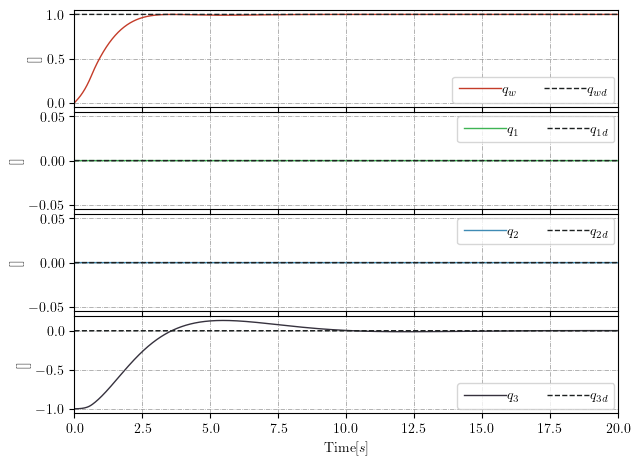

In [35]:
# PLot Results
fig11, ax11, ax21, ax31, ax41 = fancy_plots_4()
plot_states_quaternion(fig11, ax11, ax21, ax31, ax41, Q1_data[0:4, :], Q1d_data[0:4, :], t, "Quaternions Results")
plt.show()


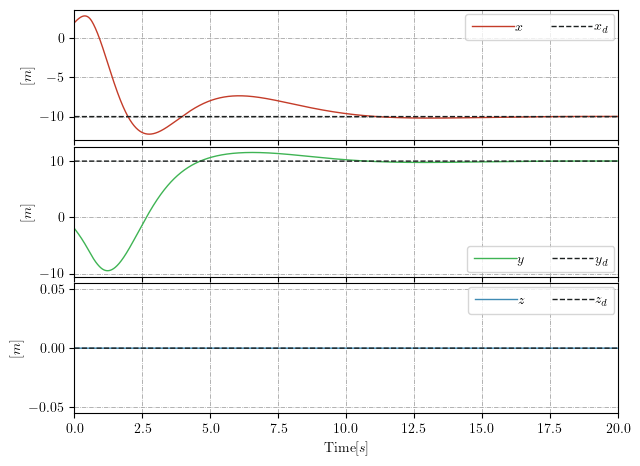

In [36]:
fig12, ax12, ax22, ax32 = fancy_plots_3()
plot_states_position(fig12, ax12, ax22, ax32, Q1_data[5:8, :], Q1d_data[5:8, :], t, "Position of the System")
plt.show()

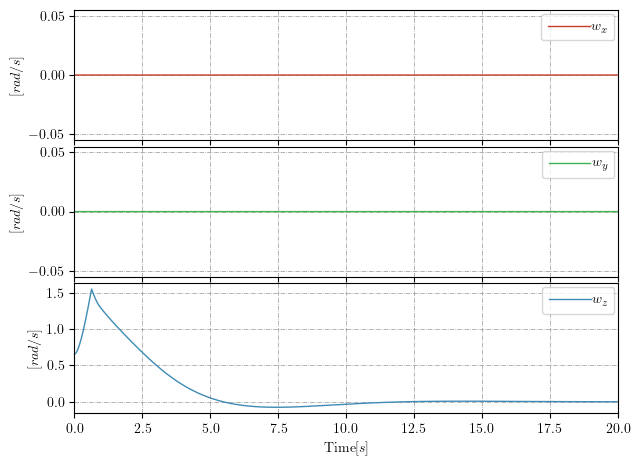

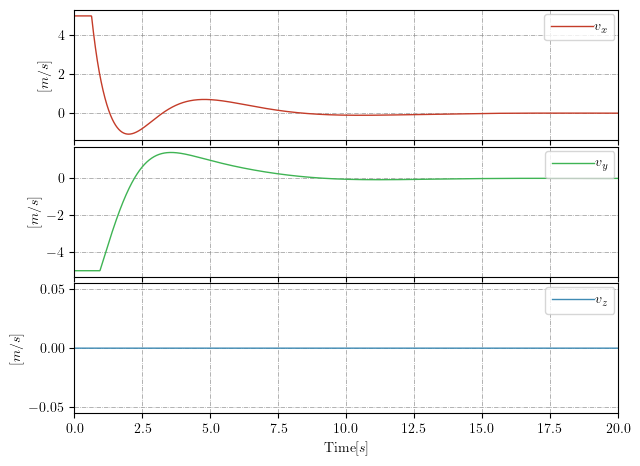

In [37]:
fig13, ax13, ax23, ax33 = fancy_plots_3()
plot_angular_velocities(fig13, ax13, ax23, ax33, w1[0:3, :], t, "Angular velocities Body")
plt.show()

fig14, ax14, ax24, ax34 = fancy_plots_3()
plot_linear_velocities(fig14, ax14, ax24, ax34, v1[0:3, :], t, "Linear velocities Body")
plt.show()

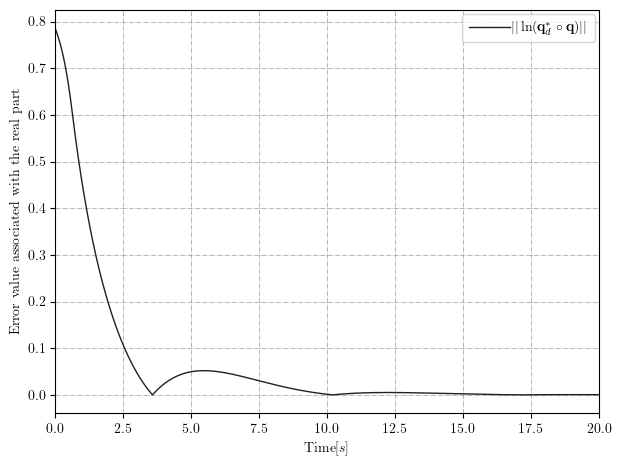

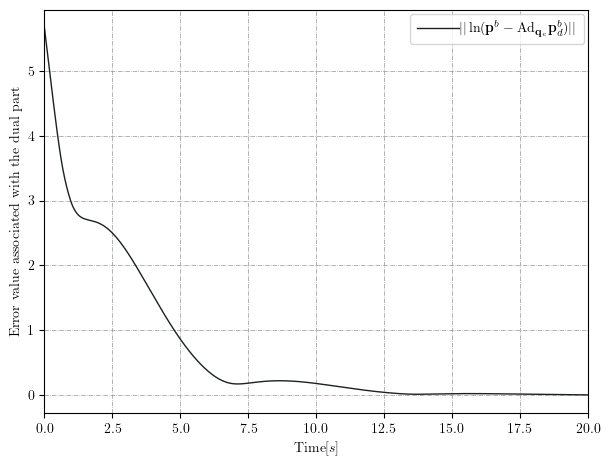

In [38]:
fig15, ax15 = fancy_plots_1()
plot_norm_real(fig15, ax15, norm_quat, t, "Quaternion Error Norm Inertial")
plt.show()

fig16, ax16 = fancy_plots_1()
plot_norm_dual(fig16, ax16, norm_trans, t, "Translation Error Norm Inertial")
plt.show()

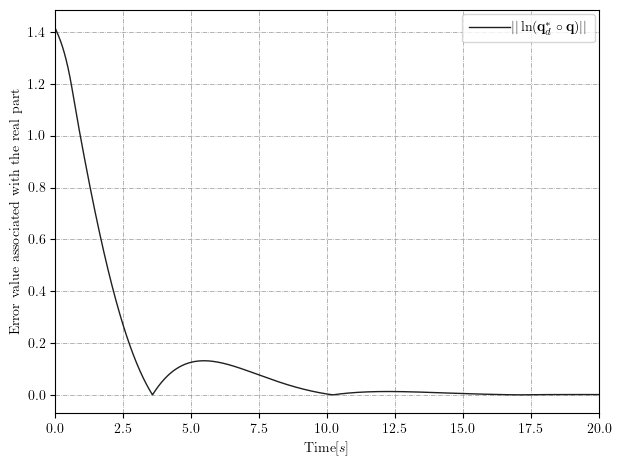

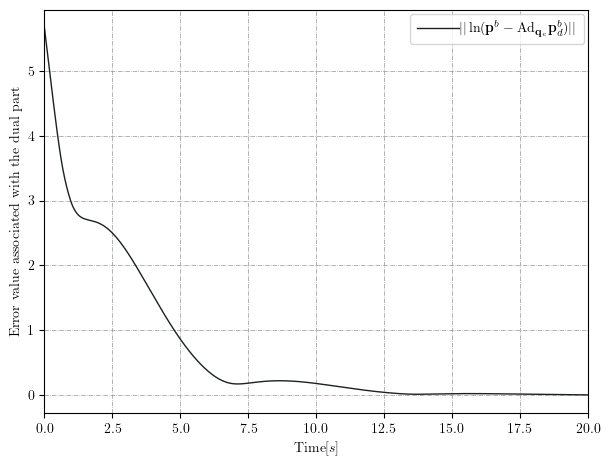

In [39]:
fig17, ax17 = fancy_plots_1()
plot_norm_real(fig17, ax17, norm_quat_aux, t, "Quaternion Error Norm Inertial")
plt.show()

fig18, ax18 = fancy_plots_1()
plot_norm_dual(fig18, ax18, norm_trans_aux, t, "Translation Error Norm Inertial")
plt.show()

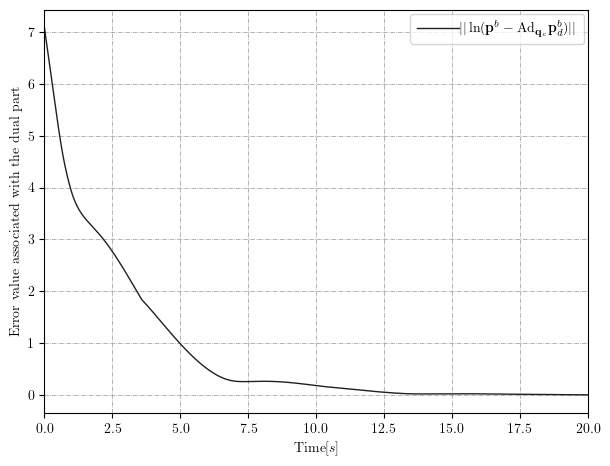

In [40]:
fig19, ax19 = fancy_plots_1()
plot_norm_dual(fig19, ax19, norm_total, t, "Complete Error Norm Inertial")
plt.show()

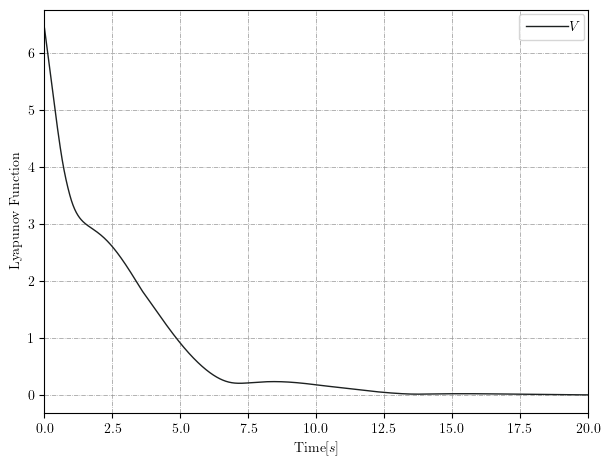

In [41]:
fig19, ax19 = fancy_plots_1()
plot_lyapunov(fig19, ax19, lyapunov_values, t, "lyapunnov")
plt.show()

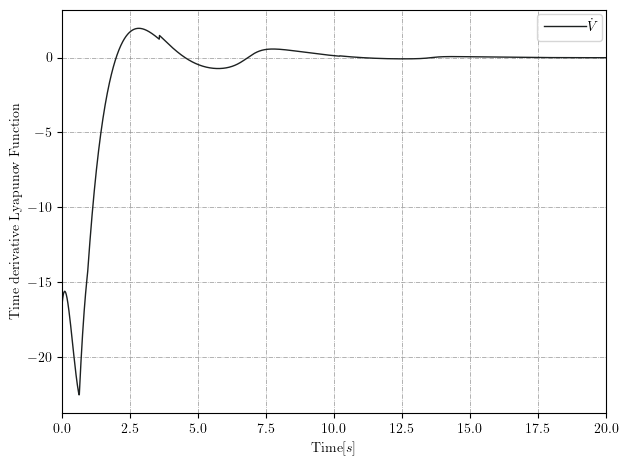

In [42]:
fig21, ax21 = fancy_plots_1()
plot_lyapunov_dot(fig21, ax21, lyapunov_dot_values, t, "lyapunnov_dot")
plt.show()

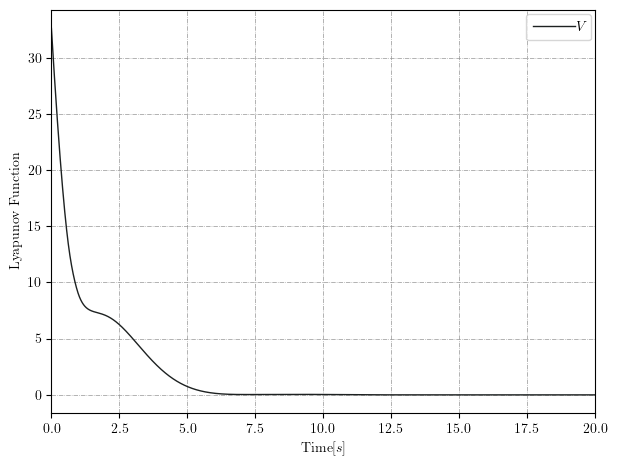

In [43]:
fig22, ax22 = fancy_plots_1()
plot_lyapunov(fig22, ax22, lyapunov_lie_values, t, "lyapunnov lie")
plt.show()

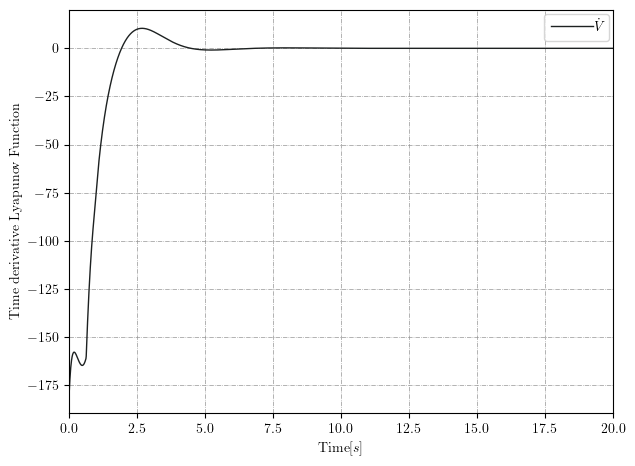

In [44]:
fig23, ax23 = fancy_plots_1()
plot_lyapunov_dot(fig23, ax23, lyapunov_lie_dot_values, t, "lyapunnov lie dot")
plt.show()